<a href="https://colab.research.google.com/github/delibae/AI_study/blob/main/honeybee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [20]:
#####################################
# Libraries
#####################################
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import math
import os
import warnings
from tqdm import tqdm
from glob import glob

# Image processing
import imageio
import skimage
import skimage.io
import skimage.transform
from PIL import Image
from sklearn.model_selection import train_test_split

# Charts
import matplotlib.pyplot as plt
import seaborn as sns


# ML
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from sklearn.preprocessing import OneHotEncoder




# Set random seed to make results reproducable
np.random.seed(42)



img_folder='/content/drive/MyDrive/data/archive/bee_imgs/bee_imgs/'
img_width=100
img_height=100
img_channels=3

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [4]:
bees=pd.read_csv('/content/drive/MyDrive/data/archive/bee_data.csv', 
                index_col=False,  
                parse_dates={'datetime':[1,2]},
                dtype={'subspecies':'category', 'health':'category','caste':'category'})

def read_img(file):
    """
    Read and resize img, adjust channels. 
    Caution: This function is not independent, it uses global vars: img_folder, img_channels
    @param file: file name without full path
    """
    img = skimage.io.imread(img_folder + file)
    img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
    return img[:,:,:img_channels]


bees.dropna(inplace=True)


img_exists = bees['file'].apply(lambda f: os.path.exists(img_folder + f))
print(img_exists)
bees = bees[img_exists]

bees.head()

print(bees)

0       True
1       True
2       True
3       True
4       True
        ... 
5167    True
5168    True
5169    True
5170    True
5171    True
Name: file, Length: 5172, dtype: bool
                datetime         file           location  zip code subspecies  \
0    2018-08-28 16:07:00  041_066.png     Alvin, TX, USA     77511         -1   
1    2018-08-28 16:07:00  041_072.png     Alvin, TX, USA     77511         -1   
2    2018-08-28 16:07:00  041_073.png     Alvin, TX, USA     77511         -1   
3    2018-08-28 16:07:00  041_067.png     Alvin, TX, USA     77511         -1   
4    2018-08-28 16:07:00  041_059.png     Alvin, TX, USA     77511         -1   
...                  ...          ...                ...       ...        ...   
5167 2018-08-20 10:03:00  027_011.png  San Jose, CA, USA     95124         -1   
5168 2018-08-20 10:03:00  027_007.png  San Jose, CA, USA     95124         -1   
5169 2018-08-20 10:03:00  027_013.png  San Jose, CA, USA     95124         -1   
5170 2018

# Dataset Analysis

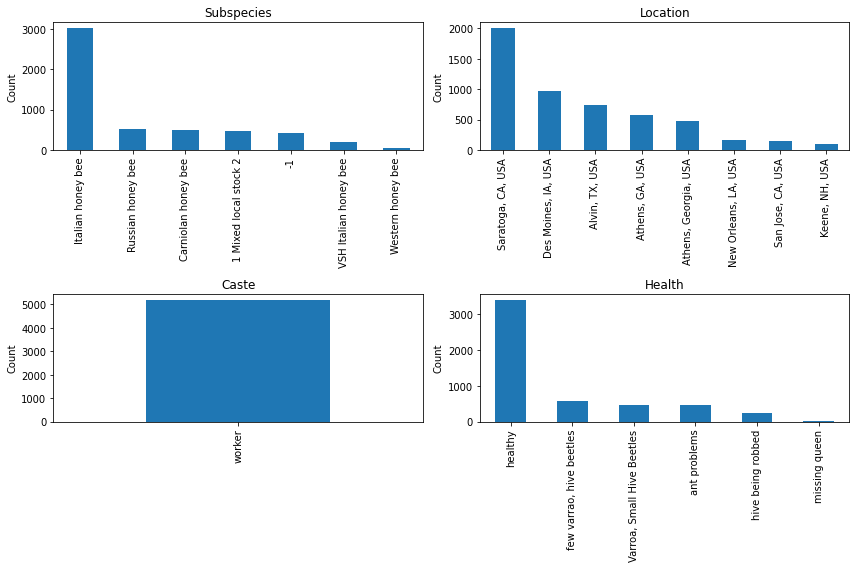

In [5]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

bees.subspecies.value_counts().plot(kind='bar',ax=ax[0, 0])
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Subspecies')

bees.location.value_counts().plot(kind='bar', ax=ax[0, 1])
ax[0,1].set_title('Location')
ax[0,1].set_ylabel('Count')

bees.caste.value_counts().plot(kind='bar', ax=ax[1, 0])
ax[1,0].set_title('Caste')
ax[1,0].set_ylabel('Count')

bees.health.value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('Health')
ax[1,1].set_ylabel('Count')

f.subplots_adjust(hspace=0.7)
f.tight_layout()
plt.show()

# Trim Data

In [7]:
print(bees)

                datetime         file           location  zip code subspecies  \
0    2018-08-28 16:07:00  041_066.png     Alvin, TX, USA     77511         -1   
1    2018-08-28 16:07:00  041_072.png     Alvin, TX, USA     77511         -1   
2    2018-08-28 16:07:00  041_073.png     Alvin, TX, USA     77511         -1   
3    2018-08-28 16:07:00  041_067.png     Alvin, TX, USA     77511         -1   
4    2018-08-28 16:07:00  041_059.png     Alvin, TX, USA     77511         -1   
...                  ...          ...                ...       ...        ...   
5167 2018-08-20 10:03:00  027_011.png  San Jose, CA, USA     95124         -1   
5168 2018-08-20 10:03:00  027_007.png  San Jose, CA, USA     95124         -1   
5169 2018-08-20 10:03:00  027_013.png  San Jose, CA, USA     95124         -1   
5170 2018-08-20 10:03:00  027_012.png  San Jose, CA, USA     95124         -1   
5171 2018-08-20 10:03:00  027_014.png  San Jose, CA, USA     95124         -1   

                 health  po

In [8]:
bees = bees.drop(columns=['datetime','location','zip code','subspecies','pollen_carrying','caste'])


In [9]:
bees.head()

,file,health
0,041_066.png,hive being robbed
1,041_072.png,hive being robbed
2,041_073.png,hive being robbed
3,041_067.png,hive being robbed
4,041_059.png,hive being robbed


In [10]:
label_list = bees['health'].unique().to_list()

In [11]:
print(label_list)

['hive being robbed', 'healthy', 'few varrao, hive beetles', 'ant problems', 'missing queen', 'Varroa, Small Hive Beetles']


In [12]:
def add(valid):
  index = label_list.index(valid)
  return index

In [13]:
bees['label'] = bees.apply(lambda row : add(row['health']), axis = 1)

In [14]:
bees = bees.drop(columns = 'health')

In [15]:
print(bees)

             file  label
0     041_066.png      0
1     041_072.png      0
2     041_073.png      0
3     041_067.png      0
4     041_059.png      0
...           ...    ...
5167  027_011.png      1
5168  027_007.png      1
5169  027_013.png      1
5170  027_012.png      1
5171  027_014.png      1

[5172 rows x 2 columns]


In [16]:
bees['file_name'] = bees.apply(lambda row : (img_folder + row['file']), axis = 1)

In [17]:
print(bees.iloc[0]['label'])
print(bees)

0
             file  label                                          file_name
0     041_066.png      0  /content/drive/MyDrive/data/archive/bee_imgs/b...
1     041_072.png      0  /content/drive/MyDrive/data/archive/bee_imgs/b...
2     041_073.png      0  /content/drive/MyDrive/data/archive/bee_imgs/b...
3     041_067.png      0  /content/drive/MyDrive/data/archive/bee_imgs/b...
4     041_059.png      0  /content/drive/MyDrive/data/archive/bee_imgs/b...
...           ...    ...                                                ...
5167  027_011.png      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
5168  027_007.png      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
5169  027_013.png      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
5170  027_012.png      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
5171  027_014.png      1  /content/drive/MyDrive/data/archive/bee_imgs/b...

[5172 rows x 3 columns]


In [18]:
bees['label'].value_counts()

1    3384
2     579
5     472
3     457
0     251
4      29
Name: label, dtype: int64

In [85]:
train, valid = train_test_split(bees, train_size=.8, shuffle=True, random_state=123, stratify=bees['label'])

In [86]:
train = train.drop(columns = ['file'])

valid = valid.drop(columns = ['file'])


In [87]:
train['label'].value_counts()


1    2707
2     463
5     377
3     366
0     201
4      23
Name: label, dtype: int64

In [88]:
valid['label'].value_counts()

1    677
2    116
5     95
3     91
0     50
4      6
Name: label, dtype: int64

In [89]:
print(train)

      label                                          file_name
3295      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
1096      3  /content/drive/MyDrive/data/archive/bee_imgs/b...
2235      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
4380      5  /content/drive/MyDrive/data/archive/bee_imgs/b...
4733      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
...     ...                                                ...
4597      5  /content/drive/MyDrive/data/archive/bee_imgs/b...
749       3  /content/drive/MyDrive/data/archive/bee_imgs/b...
750       3  /content/drive/MyDrive/data/archive/bee_imgs/b...
1528      2  /content/drive/MyDrive/data/archive/bee_imgs/b...
938       3  /content/drive/MyDrive/data/archive/bee_imgs/b...

[4137 rows x 2 columns]


In [90]:
print(valid)

      label                                          file_name
2260      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
2255      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
1101      3  /content/drive/MyDrive/data/archive/bee_imgs/b...
1968      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
2824      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
...     ...                                                ...
285       1  /content/drive/MyDrive/data/archive/bee_imgs/b...
3862      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
17        0  /content/drive/MyDrive/data/archive/bee_imgs/b...
561       1  /content/drive/MyDrive/data/archive/bee_imgs/b...
3954      1  /content/drive/MyDrive/data/archive/bee_imgs/b...

[1035 rows x 2 columns]


# Make DataLoader

## get image function

In [56]:
import cv2

def get_img_list(series) :

    
    reshaped_image_list = []

    for file_name in series :
        image_path = file_name
        # image = Image.open(image_path)
        # image = image.convert('RGB')
        # image = image.resize((100, 100))
        # image_array = np.array(image)

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.resize(image, dsize=(100, 100), interpolation=cv2.INTER_AREA)

        reshaped_image = image.reshape(100,100,3) #reshape
        reshaped_image_list.append(reshaped_image)
        
    return reshaped_image_list

## normalize image

In [57]:
def get_transform():

    t = list()
    t.append(transforms.ToTensor())
    
    # if mode == 'train':
    #     t.append(transforms.RandomAffine(degrees=10, translate=(0.1,0.1)))

    t.append(transforms.Normalize(mean=(.5),std=(.5)))
    
    return transforms.Compose(t)

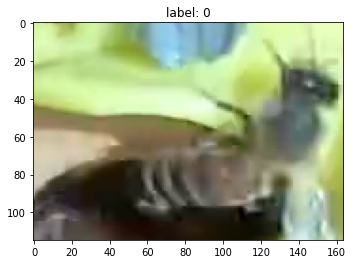

In [58]:
sample_image = Image.open(bees.iloc[0]['file_name'])
sample_label = bees['label'][0]
plt.title('label: ' + str(sample_label))
plt.imshow(sample_image, cmap='gray')

## define dataset

In [59]:
class CustomDataset(Dataset):
    def __init__(self, img_list, label=None):
        self.transform = get_transform()
        self.img_list = img_list
        self.label = label # 정답값(train)
        self.transformed_img_list = list(map(self.transform, self.img_list))

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, i):
        
        x_data = self.transformed_img_list[i]

        return x_data, torch.tensor(self.label[i],dtype = torch.long)

## define dataloader

In [60]:
def get_dataloader(x, y):
    img_list = get_img_list(x)
    dataset = CustomDataset(img_list=img_list, label=y)
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size)
    total_batch = math.ceil(len(dataset)/batch_size)

    return dataloader, total_batch

## define batchsize

In [61]:
batch_size = 64

In [91]:
train = train.reset_index(drop = True)
valid = valid.reset_index(drop = True)

In [92]:
print(train)
print(valid)

      label                                          file_name
0         1  /content/drive/MyDrive/data/archive/bee_imgs/b...
1         3  /content/drive/MyDrive/data/archive/bee_imgs/b...
2         1  /content/drive/MyDrive/data/archive/bee_imgs/b...
3         5  /content/drive/MyDrive/data/archive/bee_imgs/b...
4         1  /content/drive/MyDrive/data/archive/bee_imgs/b...
...     ...                                                ...
4132      5  /content/drive/MyDrive/data/archive/bee_imgs/b...
4133      3  /content/drive/MyDrive/data/archive/bee_imgs/b...
4134      3  /content/drive/MyDrive/data/archive/bee_imgs/b...
4135      2  /content/drive/MyDrive/data/archive/bee_imgs/b...
4136      3  /content/drive/MyDrive/data/archive/bee_imgs/b...

[4137 rows x 2 columns]
      label                                          file_name
0         1  /content/drive/MyDrive/data/archive/bee_imgs/b...
1         1  /content/drive/MyDrive/data/archive/bee_imgs/b...
2         3  /content/drive/My

## create dataloader

In [93]:
x_train = train['file_name'][:1000]
x_valid = valid['file_name'][:200]
y_train = train['label'][:1000]
y_valid = valid['label'][:200]

train_dataloader, train_total_batch = get_dataloader(x_train, y_train)
valid_dataloader, valid_total_batch = get_dataloader(x_valid, y_valid)

# test_dataloader, test_total_batch = get_dataloader(x_valid, y_valid, mode='train')


# Model

## define model

In [72]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(22 * 22 * 50, 500)
        self.fc2 = nn.Linear(500, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 50*22*22)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## cuda avaliable

In [74]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## create model

In [106]:
cnn = CNN().to(device)
# cnn = CNN()
cnn.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01)

In [95]:
output = cnn(torch.randn(10, 3, 100, 100).to(device))
# output = cnn(torch.randn(10, 3, 100, 100))
print(output)

tensor([[-0.0100, -0.0575, -0.0716,  0.0682, -0.1696, -0.0436],
        [ 0.0616, -0.1260, -0.0751,  0.0196, -0.2133, -0.0636],
        [ 0.1412, -0.0786, -0.0602,  0.0388, -0.1735, -0.0745],
        [ 0.0615, -0.0358, -0.0398, -0.0179, -0.1160, -0.0573],
        [ 0.0165, -0.0327, -0.0536,  0.0320, -0.2167, -0.0650],
        [ 0.0629, -0.0497, -0.0650, -0.0220, -0.1817, -0.0053],
        [ 0.1009, -0.0535, -0.0313,  0.0097, -0.2202, -0.0289],
        [ 0.0140, -0.0814, -0.0474,  0.0083, -0.1916, -0.0365],
        [ 0.1034, -0.0835, -0.0416,  0.0040, -0.2056, -0.0580],
        [ 0.0717, -0.0629, -0.0872, -0.0139, -0.1638, -0.0807]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


# Train

## start train

In [107]:
loss_l = []
validloss_l = []
epoch_num = 30

for epoch in range(epoch_num):
  for index, (data, target) in enumerate(train_dataloader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()  # 기울기 초기화
    output = cnn(data)
    loss = criterion(output, target)
    loss.backward()  # 역전파
    optimizer.step()

  for   index, (data, target) in enumerate(valid_dataloader):
    data = data.to(device)
    target = target.to(device)
    output = cnn(data)
    valid_loss = criterion(output,target)

  print(f"loss of {epoch} epoch, {loss.item():.3f} / valid loss: {valid_loss:.3f}")
  loss_l.append(loss.item())
  validloss_l.append(valid_loss.item())


loss of 0 epoch, 1.168 / valid loss: 0.876
loss of 1 epoch, 1.006 / valid loss: 0.820
loss of 2 epoch, 0.933 / valid loss: 0.780
loss of 3 epoch, 0.865 / valid loss: 0.763
loss of 4 epoch, 0.813 / valid loss: 0.770
loss of 5 epoch, 0.779 / valid loss: 0.785
loss of 6 epoch, 0.763 / valid loss: 0.808
loss of 7 epoch, 0.769 / valid loss: 0.850
loss of 8 epoch, 0.791 / valid loss: 0.890
loss of 9 epoch, 0.783 / valid loss: 0.892
loss of 10 epoch, 0.766 / valid loss: 0.889
loss of 11 epoch, 0.748 / valid loss: 0.894
loss of 12 epoch, 0.720 / valid loss: 0.884
loss of 13 epoch, 0.694 / valid loss: 0.874
loss of 14 epoch, 0.666 / valid loss: 0.854
loss of 15 epoch, 0.641 / valid loss: 0.839
loss of 16 epoch, 0.606 / valid loss: 0.793
loss of 17 epoch, 0.587 / valid loss: 0.798
loss of 18 epoch, 0.550 / valid loss: 0.745
loss of 19 epoch, 0.553 / valid loss: 0.804
loss of 20 epoch, 0.491 / valid loss: 0.625
loss of 21 epoch, 0.553 / valid loss: 0.608
loss of 22 epoch, 0.453 / valid loss: 0.54

## plot loss

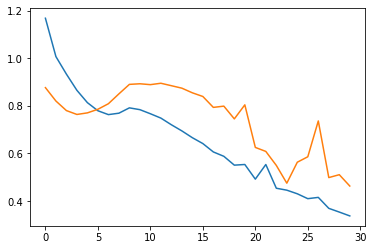

In [108]:
plt.plot(loss_l, label = "train loss")
plt.plot(validloss_l, label = "valid loss")

# Test Model

## test model

In [109]:
def get_img(file_name) :
    # series : data['file_name']
    # root_path : 이미지 파일들이 존재하는 디렉토리 경로 ('./dataset/train/')
    # return : (28,28,1) 형태의 array들이 담긴 list
    


    image_path = file_name
    image = Image.open(image_path)
    image = image.convert('RGB')
    image = image.resize((100, 100))
    image_array = np.array(image)


    reshaped_image = image_array.reshape(100,100,3) #reshape

        
    return np.array(reshaped_image)

In [110]:
def get_transform():

    t = list()
    t.append(transforms.ToTensor())
    
    # if mode == 'train':
    #     t.append(transforms.RandomAffine(degrees=10, translate=(0.1,0.1)))

    t.append(transforms.Normalize(mean=(.5),std=(.5)))
    
    return transforms.Compose(t)

In [111]:
trans= get_transform()

In [113]:
## 모드 변경

cnn.to("cpu")

CNN(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=24200, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=6, bias=True)
)

file path: /content/drive/MyDrive/data/archive/bee_imgs/bee_imgs/001_078.png
label of test data:  healthy


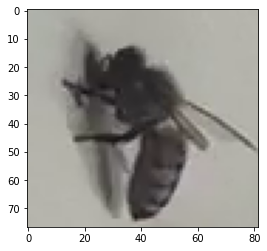

In [114]:
test_path = '/content/drive/MyDrive/data/archive/bee_imgs/bee_imgs/001_078.png'
print("file path:", test_path)
image_tensor = get_img(test_path)

trans(image_tensor)
output = cnn(trans(image_tensor))

output = F.softmax(output, dim=1)

output = output.tolist()
output = output[0]
output_index = output.index(max(output))
image = Image.open(test_path)
image = np.array(image)
plt.imshow(image)
print("label of test data: ", label_list[output_index])

# Model Analysis

## Confusion Matrix

In [116]:
cnn.eval()

CNN(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=24200, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=6, bias=True)
)

In [120]:
rows = len(label_list)
cols = len(label_list)

arr = [[0 for j in range(cols)] for i in range(rows)]


In [125]:
y_pred = []
y_true = []

# iterate over test data
for index, (inputs, labels) in enumerate(valid_dataloader):
        output = cnn(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

print(y_pred)
print(y_true)

[1, 1, 1, 0, 1, 1, 1, 5, 1, 3, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 5, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 5, 0, 1, 1, 3, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 0, 5, 1, 5, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 5, 1, 3, 1, 1, 1, 3, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 1, 2, 1, 1, 3, 1, 1, 5, 1, 1, 2, 2, 1, 1, 5, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 5, 1, 1, 5, 0, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1]
[1, 1, 3, 1, 1, 1, 1, 5, 2, 3, 3, 5, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 5, 1, 3, 1, 1, 2, 1, 2, 1, 1, 1, 1, 5, 1, 1, 1, 3, 2, 0, 1, 1, 3, 3, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 5, 5, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 5, 1, 3, 1, 1, 1, 3, 5, 1, 1, 1, 1, 3, 0, 1, 1, 1, 5, 1, 1, 3, 1, 1, 5, 1, 2, 1, 2, 0, 1, 5, 1, 1, 5, 1, 1, 5,

In [127]:
classes = label_list

In [129]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<function matplotlib.pyplot.show(*args, **kw)>

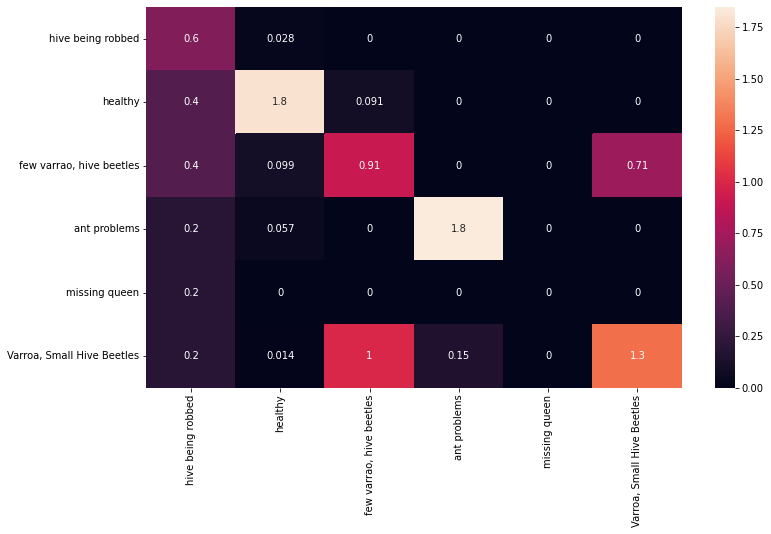

In [136]:
cf_matrix = confusion_matrix(y_true, y_pred, normalize = 'pred')
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.show

## confusion matrix 분석

### confusion matrix 를 통한 분석
1. missing queen 라벨을 제외하고 정답에 근사함
2. few varrao...(실제) 를 Varrao, Small Hive Beetles(예측) 로 착각하는 경우 잦음
3. 반대로 Varroa ..(실제) 을 few varrao ..(예측) 로 착각하는 경우도 많음